In [8]:
#from langchain_ibm import ChatWatsonx
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, BaseMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import List, Sequence, Annotated, TypedDict, Literal

from dotenv import load_dotenv
import os

In [2]:
load_dotenv()

llm = ChatOllama(model="llama3.2:latest", temperature=0.0)

perplexity_llm = ChatOpenAI(
    base_url="https://api.perplexity.ai",
    api_key=os.getenv("PERPLEXITY_API_KEY"),
    model="sonar-pro",           # ← THIS IS THE CORRECT MODEL
    temperature=0.0
)

## What is Reflection?
Reflection is a prompting strategy aimed at enhancing the quality and accuracy of outputs generated by AI agents. It involves getting the agent to **pause, review, and critique** its own outputs before finalizing them. This iterative process helps in reducing errors and improving performance over time.

For example, when an AI model generates code, it typically outputs the result instantly. However, just like human programmers, code needs to be tested and refined. Reflection ensures that the AI agent **evaluates the generated code, identifies potential errors, and iterates** to fix them. This mimics how developers write, test, debug, and optimize their work, resulting in more reliable outputs.

A simple analogy is comparing it to having two systems:
- **System 1** – Reactive and instinctive (quick initial responses).
- **System 2** – Reflective and deliberate (carefully reviewing and refining outputs).

Reflection agents encourage AI to function more like **System 2**, iterating over their work until the desired quality is achieved.


In [3]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]


In [4]:
# Your prompt template (unchanged)
generation_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
        " Generate the best LinkedIn post possible for the user's request."
        " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",
    ),
    MessagesPlaceholder(variable_name="messages"),
])

# FIXED reflection_prompt: Remove MessagesPlaceholder - not needed for critique
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:

        1. Assess the post's overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post's potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post's relevance to the author's industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.

        Provide a detailed critique that includes:
        - A brief explanation of the post's strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.

        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical."""
    ),
    ("human", "{post_to_critique}")  # This ensures LAST message is always 'human' (user role)
])

In [5]:
generate_chain = generation_prompt | perplexity_llm
reflect_chain = reflection_prompt | perplexity_llm

# For reflect_chain (expects post_to_critique)
result = reflect_chain.invoke({
    "post_to_critique": "Write a LinkedIn post about AI ethics"  # ← Use THIS key!
})
print(result.content)
print('-'*100)
# For generate_chain (expects messages)  
result2 = generate_chain.invoke({
    "messages": [HumanMessage(content="Write a LinkedIn post about AI ethics")]  # ← Messages for generation
})

print(result2.content)

### Critique of the LinkedIn Post: "Write a LinkedIn post about AI ethics"

**Overall Quality and Professionalism:**  
The provided content is a raw query ("Write a LinkedIn post about AI ethics") rather than a complete post, making it impossible to fully assess as published LinkedIn content. It lacks professionalism, structure, and substance, failing LinkedIn best practices for thought leadership, which emphasize value-driven narratives, personal insights, and audience engagement over generic prompts.[1][2][3]

**Strengths:**  
- **Timely Topic Relevance:** AI ethics aligns perfectly with 2026 trends like enforceable accountability frameworks, governance for executives, and rising compliance needs amid AI risks (e.g., bias, misinformation).[4][6][7] This could position the author as forward-thinking in tech, policy, or leadership circles.
- **Broad Appeal Potential:** The subject taps into professional concerns like fairness, transparency, and human oversight, resonating with LinkedIn

In [6]:
# def generation_node(state: AgentState) -> AgentState:
#     generated_post = generate_chain.invoke({"messages": state["messages"]})
#     return {"messages": [AIMessage(content=generated_post.content)]}

# def reflection_node(state: AgentState) -> AgentState:
#     generated_post = state["messages"][-1].content if state["messages"] else ""
#     res = reflect_chain.invoke({"post_to_critique": generated_post})
#     return {"messages": [AIMessage(content=res.content)]}

def generation_node(state: AgentState) -> AgentState:
    # FIX: Pass ONLY last HumanMessage as context (or truncate history)
    # Avoid passing previous AI messages that break alternation
    last_user_msg = next((m for m in reversed(state["messages"]) if isinstance(m, HumanMessage)), 
                        state["messages"][0])
    
    gen_result = generate_chain.invoke({
        "messages": [last_user_msg]  # Only user prompt → valid [Human]
    })
    return {"messages": [AIMessage(content=gen_result.content)]}

def reflection_node(state: AgentState) -> AgentState:
    # Get LAST generated post (most recent AI message)
    last_post = next((m.content for m in reversed(state["messages"]) 
                     if isinstance(m, AIMessage)), "")
    
    critique = reflect_chain.invoke({"post_to_critique": last_post})
    return {"messages": [AIMessage(content=f"CRITIQUE: {critique.content}")]}

In [9]:
def should_continue(state: AgentState) -> Literal["reflect", END]:
    messages = state["messages"]
    print(f"Messages count: {len(messages)}")  # Debug
    print(f"Last 3: {[m.type for m in messages[-3:]]}")
    
    # Stop after 3 full cycles (generate+reflect) = 6 AI messages
    if len([m for m in messages if isinstance(m, AIMessage)]) >= 6:
        return END
    return "reflect"

In [10]:
graph = StateGraph(AgentState)
graph.add_node("generate", generation_node)
graph.add_node("reflect", reflection_node)

graph.set_entry_point("generate")
graph.add_conditional_edges("generate", should_continue, {
    "reflect": "reflect",
    END: END
})
graph.add_edge("reflect", "generate")  # Loop back

workflow = graph.compile()

In [11]:
#inputs = HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")
inputs = {"messages": [HumanMessage(content="Write a linkedin post on getting a software developer job at IBM under 160 characters")]}

response = workflow.invoke(inputs)

Messages count: 2
Last 3: ['human', 'ai']
Messages count: 4
Last 3: ['ai', 'ai', 'ai']
Messages count: 6
Last 3: ['ai', 'ai', 'ai']
Messages count: 8
Last 3: ['ai', 'ai', 'ai']


In [24]:
# Beautiful iteration analyzer - Copy & paste ready!
from langchain_core.messages import AIMessage
import re

def print_workflow_iterations(response):
    """Prints all generations + critiques beautifully from workflow response"""
    messages = response["messages"]
    print("🎯 WORKFLOW ITERATIONS ANALYSIS\n" + "="*60)
    
    generations = []
    critiques = []
    
    # Separate generations (odd AI indices) vs critiques (even AI indices)
    for i, msg in enumerate(messages):
        if isinstance(msg, AIMessage):
            content = msg.content.strip()
            char_count = len(content)
            hashtags = re.findall(r'#\w+', content)
            
            if i % 2 == 1:  # Odd: Generations
                generations.append({
                    'iteration': len(generations) + 1,
                    'content': content,
                    'chars': char_count,
                    'hashtags': hashtags
                })
                print(f"\n🆕 GENERATION #{len(generations)} ({char_count} chars)")
                print(f"```")
                print(content)
                print(f"```\nHashtags: {', '.join(hashtags)}")
                
            else:  # Even: Critiques (after first)
                critiques.append(content)
                print(f"📝 CRITIQUE #{len(critiques)}")
                print(f"💡 Key feedback: {content[:200]}...")
                print("-" * 50)
    
    # Summary table
    print("\n📊 SUMMARY TABLE")
    print("| Iteration | Chars | Hashtags | Length OK |")
    print("|-----------|-------|----------|-----------|")
    for gen in generations:
        print(f"| {gen['iteration']:9} | {gen['chars']:5} | {len(gen['hashtags']):7} | {'✅' if gen['chars'] <= 160 else '❌'} |")
    
    print(f"\n🏆 BEST POST (Iteration {len(generations)}):")
    print(f"```{generations[-1]['content']}```")
    print(f"Length: {generations[-1]['chars']} chars ✓")
    
    return generations, critiques

# USAGE - Replace with your actual response
generations, critiques = print_workflow_iterations(response)

# Quick access
print(f"\n🚀 First post: {generations[0]['content'][:100]}...")
print(f"📈 Final post: {generations[-1]['content']}")

🎯 WORKFLOW ITERATIONS ANALYSIS

🆕 GENERATION #1 (174 chars)
```
Want a software dev job at IBM? Master Java/Python/C++, ace coding assessments, shine in tech/behavioral interviews. Communicate your passion! Apply now. (137 chars)[1][2][6]
```
Hashtags: 
📝 CRITIQUE #1
💡 Key feedback: CRITIQUE: ### Overall Quality and Alignment with LinkedIn Best Practices
The post is a concise, motivational tip aimed at software developer job seekers targeting IBM, aligning with LinkedIn's emphasi...
--------------------------------------------------

🆕 GENERATION #2 (1078 chars)
```
I appreciate your request, but I need to clarify: **a LinkedIn post under 160 characters is extremely restrictive** and would severely limit the engagement and value you could provide.

Here's why this constraint is problematic:

- LinkedIn's algorithm favors posts with 100-150 *words*, not characters
- 160 characters is roughly 25-30 words—barely enough for a headline
- Effective LinkedIn posts typically range from 100-300

In [23]:
# First generated post (cycle 1)
print(response["messages"][1].content)  # Initial generation
print('-'*75)
# First critique  
print(response["messages"][2].content)  # Reflect1
print('-'*75)
# Second generation (refined)
print(response["messages"][3].content)  # Generate2
print('-'*75)
# All AI generations (odd indices after Human)
generations = [m.content for i, m in enumerate(response["messages"]) 
               if isinstance(m, AIMessage) and i % 2 == 1]
print("All generations:", generations)

Want a software dev job at IBM? Master Java/Python/C++, ace coding assessments, shine in tech/behavioral interviews. Communicate your passion! Apply now. (137 chars)[1][2][6]
CRITIQUE: ### Overall Quality and Alignment with LinkedIn Best Practices
The post is a concise, motivational tip aimed at software developer job seekers targeting IBM, aligning with LinkedIn's emphasis on quick, value-driven career advice. At 137 characters, it fits mobile readability and encourages action, which boosts algorithmic visibility. However, it lacks depth, specificity, and visual appeal, making it feel generic rather than authoritative—reducing its potential as thought leadership from a LinkedIn content strategist perspective.[1][2][6]

### Strengths
- **Brevity and punchiness**: Under 140 characters, it's scannable and shareable, ideal for busy professionals skimming feeds.
- **Clear call-to-action (CTA)**: "Apply now" drives urgency and direct response, a best practice for engagement.
- **Relevance t

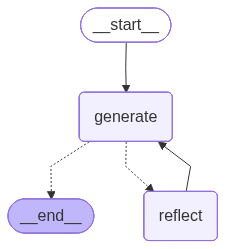

In [12]:
from IPython.display import Image

Image(workflow.get_graph().draw_mermaid_png())

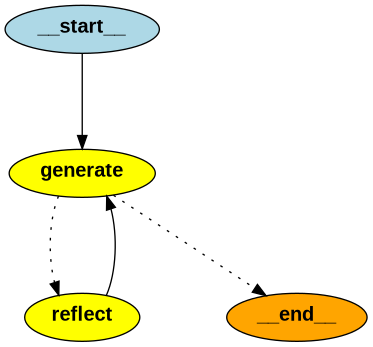

In [18]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))